In [1]:
# Python : 3.10.16
# Created: May. 26. 2025
# Author: Jinu Cho
# Description: qwen3 모델을 활용하여 로컬 PC에서 M&A 데이터 파인튜닝하기
# Huggingface와 WandB를 이용합니다.
#
# 참고문서 : https://github.com/datawhalechina/self-llm/blob/master/models/Qwen2/05-Qwen2-7B-Instruct%20Lora.ipynb
# 데이터셋 출처 : AI Hub 및 자체 크롤링

In [2]:
# # 필요 라이브러리 설치
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 && \
# pip install transformers datasets accelerate peft bitsandbytes trl wandb huggingface_hub

# 1. 모델 학습

## 1. 라이브러리 로드

In [3]:
import pandas as pd
import torch
import wandb
from datasets import Dataset
from peft import LoraConfig, TaskType, get_peft_model
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    TrainingArguments,
)
from trl import SFTTrainer
import warnings

warnings.filterwarnings("ignore")

## 2. 데이터 로드

In [4]:
labeled_df = pd.read_csv("../data/labeled_qa_data.csv")

<Axes: ylabel='Frequency'>

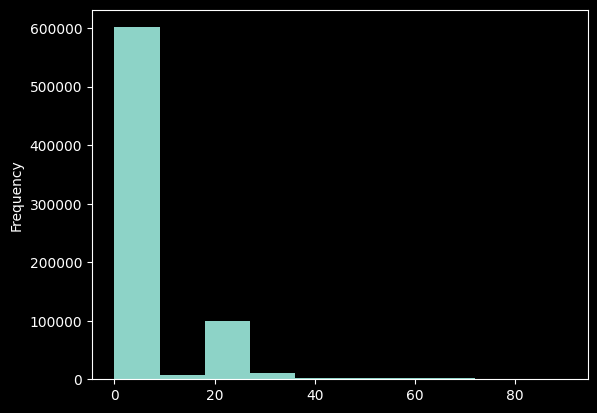

In [5]:
labeled_df.score.plot.hist()

In [6]:
filtered_df = labeled_df.query("score > 30")
print(filtered_df.shape)
filtered_df.head()

(9605, 6)


,index,question,answer,category,score,reason
63,63,시설관리공단의 재정현황에 대해 설명해주세요.,"시설관리공단은 2007년에 총 수입이 713억 원이고, 총 지출은 590억 원이었습...",기타,40,"이 답변은 시설관리공단의 특정 연도의 재정 현황을 설명하고 있지만, M&A와 직접적..."
169,169,부산관광개발 주식회사가 매출을 어떤 방식으로 올리고 있나요?,부산관광개발 주식회사는 매출을 주로 입장 수입과 카대여 수입으로 올리고 있습니다. ...,사회,70,"이 질문과 답변은 부산관광개발 주식회사의 매출 요소에 대한 정보를 제공하므로, M&..."
171,171,부산관광개발 주식회사의 재무상태는 어떻게 되나요?,부산관광개발 주식회사의 재무상태는 현재까지 12억원 정도의 이익을 기록하고 있습니다...,사회,65,"이 데이터는 부산관광개발 주식회사의 재무상태를 간접적으로 보여주지만, 이는 M&A에..."
172,172,부산경륜공단의 매출액은 어떻게 변화하고 있는가?,"부산경륜공단의 매출액은 2004년에 773억 원이었으며, 창원은 4,668억 원으로...",사회,35,"데이터는 부산경륜공단의 매출액에 대한 정보를 제공하지만, M&A 분야에 직접적으로 ..."
304,304,R&D 유치 사업 내역에 대해 언급된 부산테크노파크와 부산과학기술기획평가원의 역할은...,"부산테크노파크와 부산과학기술기획평가원은 모두 R&D 유치 사업을 수행하는 기관으로,...",사회,40,"주어진 데이터는 R&D와 관련된 정보를 제공하지만, M&A 분야에서는 직접적으로 활..."


In [7]:
mna_df = pd.read_json("../data/mna_qa_data.json")
mna_df

,question,answer,source
0,M&A란 무엇인가요?,"M&A는 Merger & Acquisition의 약자로, 기업의 합병과 인수를 통칭...","M&A는 Merger & Acquisition의 약자로, 기업의 합병과 인수를 통칭..."
1,M&A의 주요 종류는 무엇인가요?,"M&A의 종류는 크게 합병, 인수, 분할로 나눌 수 있습니다.","M&A의 종류는 크게 합병, 인수, 분할로 나눌 수 있습니다."
2,합병의 두 가지 유형은 무엇인가요?,합병은 크게 흡수합병과 신설합병으로 나눌 수 있습니다.,합병은 크게 흡수합병과 신설합병으로 나눌 수 있습니다.
3,흡수합병이란 무엇인가요?,"흡수합병은 한 회사가 다른 회사를 합병하여 소멸하는 것을 말하며, 존속회사가 소멸회...",흡수합병은 한 회사가 다른 회사를 합병하여 소멸하는 것을 말합니다. 흡수합병의 경우...
4,신설합병의 정의는 무엇인가요?,"신설합병은 두 개 이상의 회사가 합병하여 새로운 회사를 설립하는 것을 말하며, 신설...",신설합병은 두 개 이상의 회사가 합병하여 새로운 회사를 설립하는 것을 말합니다. 신...
...,...,...,...
1520,합병의 두 가지 방식은 무엇인가요?,합병의 두 가지 방식은 신설합병과 흡수합병입니다.,"합병 방식은 다시 1) 신설합병, 2) 흡수합병 2가지 형태로 나누어볼 수 있습니다."
1521,신설합병이란 무엇인가요?,신설합병은 합병에 참여한 회사들이 모두 해산하고 새로운 회사가 신설되는 것을 말합니다.,신설합병은 합병에 참여한 회사들이 모두 해산하고 새로운 회사가 신설되는 것을말합니다.
1522,흡수합병의 특징은 무엇인가요?,"흡수합병은 한 회사가 다른 회사를 흡수하여 하나의 회사가 되는 것으로, 합병에 참여...",흡수합병은 한 회사가 다른 회사에 말 그대로 흡수되어 하나의 회사가 되는 것을말합니...
1523,기업이 인수를 통해 얻는 장점은 무엇인가요?,"기업은 인수를 통해 경쟁력을 빠르게 강화할 수 있으며, 비효율적인 경영을 개선하고 ...",기업은 인수를 통해 기업의 경쟁력을 빠르게 강화할 수 있다는 장점이 있습니다. 특정...


In [8]:
qa_filtered_df = filtered_df.iloc[:, 1:3]
qa_mna_df = mna_df.iloc[:, :2]
train_df = pd.concat([qa_filtered_df, qa_mna_df], ignore_index=True)

In [9]:
train_df

,question,answer
0,시설관리공단의 재정현황에 대해 설명해주세요.,"시설관리공단은 2007년에 총 수입이 713억 원이고, 총 지출은 590억 원이었습..."
1,부산관광개발 주식회사가 매출을 어떤 방식으로 올리고 있나요?,부산관광개발 주식회사는 매출을 주로 입장 수입과 카대여 수입으로 올리고 있습니다. ...
2,부산관광개발 주식회사의 재무상태는 어떻게 되나요?,부산관광개발 주식회사의 재무상태는 현재까지 12억원 정도의 이익을 기록하고 있습니다...
3,부산경륜공단의 매출액은 어떻게 변화하고 있는가?,"부산경륜공단의 매출액은 2004년에 773억 원이었으며, 창원은 4,668억 원으로..."
4,R&D 유치 사업 내역에 대해 언급된 부산테크노파크와 부산과학기술기획평가원의 역할은...,"부산테크노파크와 부산과학기술기획평가원은 모두 R&D 유치 사업을 수행하는 기관으로,..."
...,...,...
11125,합병의 두 가지 방식은 무엇인가요?,합병의 두 가지 방식은 신설합병과 흡수합병입니다.
11126,신설합병이란 무엇인가요?,신설합병은 합병에 참여한 회사들이 모두 해산하고 새로운 회사가 신설되는 것을 말합니다.
11127,흡수합병의 특징은 무엇인가요?,"흡수합병은 한 회사가 다른 회사를 흡수하여 하나의 회사가 되는 것으로, 합병에 참여..."
11128,기업이 인수를 통해 얻는 장점은 무엇인가요?,"기업은 인수를 통해 경쟁력을 빠르게 강화할 수 있으며, 비효율적인 경영을 개선하고 ..."


In [10]:
train_df = train_df.iloc[:, :2]
train_df["input"] = ""

# 비추론 모드를 위한 토큰 추가
train_df["question"] = train_df["question"] + "/no_think"
train_df["answer"] = "<think>\n\n</think>\n\n" + train_df["answer"]

In [11]:
train_df

,question,answer,input
0,시설관리공단의 재정현황에 대해 설명해주세요./no_think,<think>\n\n</think>\n\n시설관리공단은 2007년에 총 수입이 71...,
1,부산관광개발 주식회사가 매출을 어떤 방식으로 올리고 있나요?/no_think,<think>\n\n</think>\n\n부산관광개발 주식회사는 매출을 주로 입장 ...,
2,부산관광개발 주식회사의 재무상태는 어떻게 되나요?/no_think,<think>\n\n</think>\n\n부산관광개발 주식회사의 재무상태는 현재까지...,
3,부산경륜공단의 매출액은 어떻게 변화하고 있는가?/no_think,<think>\n\n</think>\n\n부산경륜공단의 매출액은 2004년에 773...,
4,R&D 유치 사업 내역에 대해 언급된 부산테크노파크와 부산과학기술기획평가원의 역할은...,<think>\n\n</think>\n\n부산테크노파크와 부산과학기술기획평가원은 모...,
...,...,...,...
11125,합병의 두 가지 방식은 무엇인가요?/no_think,<think>\n\n</think>\n\n합병의 두 가지 방식은 신설합병과 흡수합병...,
11126,신설합병이란 무엇인가요?/no_think,<think>\n\n</think>\n\n신설합병은 합병에 참여한 회사들이 모두 해...,
11127,흡수합병의 특징은 무엇인가요?/no_think,<think>\n\n</think>\n\n흡수합병은 한 회사가 다른 회사를 흡수하여...,
11128,기업이 인수를 통해 얻는 장점은 무엇인가요?/no_think,<think>\n\n</think>\n\n기업은 인수를 통해 경쟁력을 빠르게 강화할...,


In [12]:
dataset = Dataset.from_pandas(train_df)
dataset[:3]

{'question': ['시설관리공단의 재정현황에 대해 설명해주세요./no_think',
  '부산관광개발 주식회사가 매출을 어떤 방식으로 올리고 있나요?/no_think',
  '부산관광개발 주식회사의 재무상태는 어떻게 되나요?/no_think'],
 'answer': ['<think>\n\n</think>\n\n시설관리공단은 2007년에 총 수입이 713억 원이고, 총 지출은 590억 원이었습니다. 대행사업의 경우에는 수입이 624억 원, 지출이 515억 원으로 예상수지율은 109억 원이었습니다. 이를 통해 공단의 재정 상황은 수입과 지출 간의 균형을 유지하며 운영되고 있음을 알 수 있습니다.',
  '<think>\n\n</think>\n\n부산관광개발 주식회사는 매출을 주로 입장 수입과 카대여 수입으로 올리고 있습니다. 입장 수입은 아시아드 CC에 골프를 하러 오는 사람들의 입장료 수입을 말하며, 기타 매출에는 식음료와 프로숍 등의 서비스로부터 계약을 통해 발생한 수입이 포함되어 있습니다. 예를 들어, 식음료 수입은 1억 9,400만원 정도이며, 각각의 서비스로부터 수입을 받고 있습니다.',
  '<think>\n\n</think>\n\n부산관광개발 주식회사의 재무상태는 현재까지 12억원 정도의 이익을 기록하고 있습니다. 하지만 작년 대비하여 올해는 5억 3,000만원 정도의 마이너스 이익이 발생한 것으로 보고되었습니다. 이는 주로 비용 증가와 수익 감소 등으로 인해 발생한 것으로 보고되며, 회사는 이를 분석하고 개선책 모색에 노력하고 있습니다.'],
 'input': ['', '', '']}

In [13]:
dataset

Dataset({
    features: ['question', 'answer', 'input'],
    num_rows: 11130
})

## 3. 토크나이저 설정

In [14]:
model_name = "Qwen/Qwen3-8B"

tokenizer = AutoTokenizer.from_pretrained(
    model_name, use_fast=False, trust_remote_code=True
)

tokenizer

Qwen2Tokenizer(name_or_path='Qwen/Qwen3-8B', vocab_size=151643, model_max_length=131072, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False, normalized=Fals

In [15]:
def process_func(example):
    MAX_LENGTH = 384  # Llama 토크나이저는 한 개의 한자를 여러 개의 토큰으로 분할하므로, 데이터의 완전성을 보장하기 위해 최대 길이를 여유 있게 설정
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer(
        f"<|im_start|>system\n당신은 금융,법률 및 M&A 분야 전문가입니다.\n사용자 질문에 대해 반드시 한국어로만 답변하세요..<|im_end|>\n<|im_start|>user\n{example['question'] + example['input']}<|im_end|>\n<|im_start|>assistant\n",
        add_special_tokens=False,  # 시작 부분에 special tokens를 추가하지 않음
    )
    response = tokenizer(f"{example['answer']}<|im_end|>", add_special_tokens=False)
    input_ids = (
        instruction["input_ids"] + response["input_ids"] + [tokenizer.pad_token_id]
    )
    attention_mask = (
        instruction["attention_mask"] + response["attention_mask"] + [1]
    )  # eos 토큰도 주목해야 하므로 1로 채움
    labels = (
        [-100] * len(instruction["input_ids"])  # 지시문 부분은 무시
        + response["input_ids"]
        + [tokenizer.pad_token_id]
    )
    if len(input_ids) > MAX_LENGTH:  # 길이 초과 시 잘라냄
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [16]:
tokenized_id = dataset.map(process_func, remove_columns=dataset.column_names)
tokenized_id

Map:   0%|          | 0/11130 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 11130
})

In [17]:
tokenizer.decode(tokenized_id[0]["input_ids"])

'<|im_start|>system\n당신은 금융,법률 및 M&A 분야 전문가입니다.\n사용자 질문에 대해 반드시 한국어로만 답변하세요..<|im_end|>\n<|im_start|>user\n시설관리공단의 재정현황에 대해 설명해주세요./no_think<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n시설관리공단은 2007년에 총 수입이 713억 원이고, 총 지출은 590억 원이었습니다. 대행사업의 경우에는 수입이 624억 원, 지출이 515억 원으로 예상수지율은 109억 원이었습니다. 이를 통해 공단의 재정 상황은 수입과 지출 간의 균형을 유지하며 운영되고 있음을 알 수 있습니다.<|im_end|><|endoftext|>'

In [18]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_id[1]["labels"])))

'<think>\n\n</think>\n\n부산관광개발 주식회사는 매출을 주로 입장 수입과 카대여 수입으로 올리고 있습니다. 입장 수입은 아시아드 CC에 골프를 하러 오는 사람들의 입장료 수입을 말하며, 기타 매출에는 식음료와 프로숍 등의 서비스로부터 계약을 통해 발생한 수입이 포함되어 있습니다. 예를 들어, 식음료 수입은 1억 9,400만원 정도이며, 각각의 서비스로부터 수입을 받고 있습니다.<|im_end|><|endoftext|>'

## 4. 모델 로드

In [19]:
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", torch_dtype=torch.bfloat16
)
model

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): 

In [20]:
model.enable_input_require_grads()

In [21]:
model.dtype

torch.bfloat16

## 5. LoRA 설정

In [22]:
config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # 언어 모델링 작업 (Causal Language Modeling)
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # LoRA를 적용할 모델의 모듈 목록
    inference_mode=False,  # 학습 모드 (True로 설정하면 추론 모드)
    r=8,  # LoRA의 랭크 (병렬 행렬의 차원 수)
    lora_alpha=32,  # LoRA alpha 값, 세부적인 역할은 논문 참조
    lora_dropout=0.1,  # Dropout 비율
)
config

LoraConfig(task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, inference_mode=False, r=8, target_modules={'v_proj', 'k_proj', 'down_proj', 'gate_proj', 'o_proj', 'up_proj', 'q_proj'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)

In [23]:
model = get_peft_model(model, config)
config

LoraConfig(task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='Qwen/Qwen3-8B', revision=None, inference_mode=False, r=8, target_modules={'v_proj', 'k_proj', 'down_proj', 'gate_proj', 'o_proj', 'up_proj', 'q_proj'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)

In [24]:
# !wandb login

## 6. WandB 설정

In [25]:
wandb.login()  # 🔥 API Key를 환경변수에 설정하지 않고 로그인 수행

wandb.init(
    project="Qwen3-8B-M&A",
    name="qlora_finetuning-qwen3-8B-mna",
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: duojinwu (duojinwu-koreamnaexchage) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 7. 학습 파라미터 설정

In [26]:
training_args = TrainingArguments(
    output_dir="./models/Qwen3-8B-mna-Finetuned",  # 로컬 모델 저장 경로
    logging_dir="./models/log",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch",
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    lr_scheduler_type="linear",
    push_to_hub=False,
)

## 8. 학습 시작

### ```DataCollatorForSeq2Seq```

- encoder-decoder 구조(예: T5, BART 등)에서 input_ids와 labels를 동시에 패딩 처리하고, 필요한 경우 decoder_input_ids까지 자동 생성
- 주요 사용 목적은 labels도 함께 패딩하여 길이를 정렬
- 현재 코드에서는 토크나이저 함수에서 패팅처리를 하고 있으므로, 굳이 필요없음

### 추가 ```DataCollatorWithPadding```

만약 decoder-only 모델에서 사용할 경우 사용 권장 됨 

- label 처리 코드가 별도로 되어 있다고 가정
- tokenizer 기준으로 각 샘플의 최대 길이에 맞춰 오른쪽 패딩 추가


In [27]:
# 📌 7. Trainer 생성
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_id,
    peft_config=config,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
    args=training_args,
)

Truncating train dataset:   0%|          | 0/11130 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [28]:
# 📌 8. 학습 실행
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
10,2.089700
20,2.086700
30,1.762000
40,1.503600
50,1.444700
60,1.419600
70,1.304700
80,1.375000
90,1.396900
100,1.436200


TrainOutput(global_step=4173, training_loss=1.1690776298979104, metrics={'train_runtime': 4026.9737, 'train_samples_per_second': 8.292, 'train_steps_per_second': 1.036, 'total_flos': 3.134263922191688e+17, 'train_loss': 1.1690776298979104})

## 학습 모델 저장

In [33]:
trainer.save_model("./models/Qwen3-8B-mna-Finetuned")
tokenizer.save_pretrained("./models/Qwen3-8B-mna-Finetuned")

('./models/Qwen3-8B-mna-Finetuned/tokenizer_config.json',
 './models/Qwen3-8B-mna-Finetuned/special_tokens_map.json',
 './models/Qwen3-8B-mna-Finetuned/vocab.json',
 './models/Qwen3-8B-mna-Finetuned/merges.txt',
 './models/Qwen3-8B-mna-Finetuned/added_tokens.json')

# 2. 모델 테스트 및 평가

## 1. 모델 로드

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from peft import PeftModel

model_name = "Qwen/Qwen3-8B"
lora_path = "models/Qwen3-8B-mna-Finetuned"

# tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True, use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id


# 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", torch_dtype=torch.bfloat16, trust_remote_code=True
).eval()

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## 모델 평가

In [2]:
# 📌 11. 테스트 (질문-응답 생성 함수)
def generate_answer(question):
    inputs = tokenizer.apply_chat_template(
        [
            {
                "role": "system",
                "content": "당신은 금융,법률 및 M&A 분야 전문가입니다.\n사용자 질문에 대해 반드시 한국어로만 답변하세요.",
            },
            {"role": "user", "content": question + "/no_think"},
        ],
        add_generation_prompt=True,
        tokenize=True,
        return_tensors="pt",
        return_dict=True,
    ).to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=1024,
            temperature=0.1,
            top_k=2,
            top_p=0.95,
            repetition_penalty=1.2,
            do_sample=True,
        )
        outputs = outputs[:, inputs["input_ids"].shape[1] :]
        outputs = tokenizer.decode(outputs[0], skip_special_tokens=True)
        outputs = outputs.split("</think>")[1].strip()
        return outputs

In [ ]:
query1 = "M&A란 무엇인가요?"
result_basic1 = generate_answer(query1)
print(f"기본 모델: {result_basic1}")

기본 모델: M&A는 **합병**(Merger)과 **수주**(Acquisition)의 약자로, 기업 간의 자본 통합이나 소유권 이전을 의미합니다.

- **합병(Merger)**: 두 개 이상의 회사를 하나의 새로운 회사로 합쳐주는 행위를 말하며, 일반적으로 양측이 동등한 지분을 가지고 참여하는 경우较多합니다.
  
- **수주(Acquisition)**: 한쪽 기업이 다른 기업을 인수하여 운영을 장악하거나 통제하게 되는 방식으로, 수주기업이 피수주기업의 주식 또는 자산을 구매함으로써 이루어집니다.

M&A는 시장 확대, 경영 효율화, 신기술·시장 진입 등 다양한 이유로 진행되며, 법적 절차와 재무적 평가 등을 통해 철저히 검토됩니다. 특히, 법률, 회계, 세금 등의 전문성을 갖춘 컨설팅 서비스가 필수적인 과정입니다.


In [4]:
query2 = "M&A시 고려해야 할 사항들에 대해 알려주세요."
result_basic2 = generate_answer(query2)
print(f"기본 모델: {result_basic2}")

기본 모델: M&A(합병·인수)는 기업의 성장과 경영전략을 위한 중요한 결정이므로, 철저한 준비와 검토가 필요합니다. 아래에는 M&A 시 주요하게 고려해야 할 사항들을 정리해 드립니다.

---

### 1. **목표 설정**
- **왜 M&A를 진행하나?** (시장 확대, 제품/서비스 다각화, 기술 획득 등)
- **기대 효과** (재무적 이익, 운영 효율성 향상, 브랜드 강화 등)

---

### 2. **타겟 선정**
- **산업별 동향**, **경쟁 구도**, **시장 점유율** 등을 분석하여 적절한 대상을 선택
- **비교 분석**(SWOT 분석, PESTEL 분석 등 활용)

---

### 3. **실제 가치 평가**
- **재무적 가치**: 수익성, 현금흐름, 자산 가격 등
- **회계학적 방법**(DCF, DCF 모델, 비교기업법 등)
- **비용 중심 접근**(구매 비용 vs. 예상 수익)

---

### 4. **계약 조건 협상**
- **거래 방식**(현금 지급, 주식 교환, 채권 발행 등)
- **결제 조건**(즉시 결제, 유예 결제, 단계적 결제 등)
- **보통주 / 우선주 배분 비중**

---

### 5. **법적 리스크 관리**
- **계약 위반 가능성**, **소송 내역**, **규제 문제** 확인
- **지적 재산권 권리 명확화**
- **노동 법 준수 여부**, **고객 데이터 보호 규정 준수 여부**

---

### 6. **문화적 통합 및 조직 변화**
- **조직 문화 차이**, **핵심 인력 유지**, **내부 커뮤니케이션 계획**
- **운영 프로세스 통합**, **IT 시스템 호환성**

---

### 7. **재무적 영향 분석**
- **차입 증가**, **부채 감소**, **자본 구조 변경**
- **손익 계산서**, **재무 상태 표준치**, **투명성 제고**

---

### 8. **공개 정보 공유 및 소액주주 참여**
- **투자자 설명 회의**, **공개 보고서 작성**
- **소액주주의 

In [5]:
# LoRA 가중치 로드
finetuned_model = PeftModel.from_pretrained(model, model_id=lora_path)


def generate_answer_finetuned(question):
    inputs = tokenizer.apply_chat_template(
        [
            {
                "role": "system",
                "content": "당신은 금융,법률 및 M&A 분야 전문가입니다.\n사용자 질문에 대해 반드시 한국어로만 답변하세요.",
            },
            {"role": "user", "content": question + "/no_think"},
        ],
        add_generation_prompt=True,
        tokenize=True,
        return_tensors="pt",
        return_dict=True,
    ).to("cuda")
    with torch.no_grad():
        outputs = finetuned_model.generate(
            **inputs,
            max_length=1024,
            temperature=0.1,
            top_k=2,
            top_p=0.95,
            repetition_penalty=1.2,
            do_sample=True,
        )
        outputs = outputs[:, inputs["input_ids"].shape[1] :]
        outputs = tokenizer.decode(outputs[0], skip_special_tokens=True)
        outputs = outputs.split("</think>")[1].strip()
        return outputs

In [8]:
query1 = "M&A란 무엇인가요?"
result_finetuned1 = generate_answer_finetuned(query1)
print(f"파인튜닝 모델: {result_finetuned1}")

파인튜닝 모델: M&A는 기업의 성장과 발전을 위한 중요한 수단으로, 두 개 이상의 회사를 합병하거나 인수하는 과정을 의미합니다. 이는 새로운 시장을 공략하고 경쟁 우위를 확보하기 위해 사용됩니다.


In [9]:
query2 = "M&A시 고려해야 할 사항들에 대해 알려주세요."
result_finetuned2 = generate_answer_finetuned(query2)
print(f"파인튜닝 모델: {result_finetuned2}")

파인튜닝 모델: M&A 시에는 다양한 요소들을 신중하게 고려해야 합니다.

1. 기업 가치 평가: 인수 대상 회사를 적절히 평가하여 그들의 실제 가치를 파악하는 것이 중요합니다. 이를 위해 재무적 지표와 비재무적 요인을 모두 고려해야 하며, 경쟁력과 성장 가능성 등도 검토되어야 합니다.

2. 문화적 조화: 두 조직의 문화는 합병 후에도 영향력을 미칩니다. 서로 다른 업종이나 지역에서 온 직원들이 함께 일할 때 발생할 수 있는 갈등을 예방하기 위해서는 충분한 준비와 소통이 필요합니다.

3. 통합 계획: 인수 이후의 통합 과정은 매우 복잡하고 도전적이기 때문에 철저한 계획이 요구됩니다. 이는 운영 프로세스, IT 시스템, 마케팅 전략 등을 포함하며, 모든 부서와 팀에게 명확한 방향성을 제시해야 합니다.

4. 법적 문제: M&A 거래는 많은 법률적인 측면을 가지고 있습니다. 이러한 점들은 자산 매각, 계약 해지, 노동 관련 규정 준수 등의 문제가 될 수 있으므로, 전문적인 법률 컨설팅을 받고 해당 위험을 최소화하는 방법을 모색해야 합니다.

5. 장기적인 목표 설정: M&A의 목적은 단순히 한 번의 거래를 완료하는 것을 넘어 장기적으로 어떤 결과를 얻기를 원하는지를 명확히 정해져 있어야 합니다. 새로운 사업 확장을 통해 시장점유율 증대나 제품 라인 다양화 같은 목표를 설정하면 더 나은 결정을 내릴 수 있을 것입니다.

6. 리스크 관리: 모든 거래에는 불확실성이 존재하므로, 잠재적인 리스크를 심층적으로 분석하고 효과적인 관리를 위한 전략을 마련하는 것이 필수적입니다. 특히 시장 변동성, 규제 변화, 경쟁 환경 등 외부 요인이 어떻게 거래에 영향을 줄 것인지 면밀히 살펴봐야 합니다.

7. 의사결정 구조: 인수된 회사와 본사 사이의 의사결정 구조를 명확히 하고 효율적인 정보 공유 메커니즘을 설립하는 것은 중요한데, 이를 통해 협력과 유연성을 유지하면서 동시에 각자의 독립성을 존중하는 균형점을 찾는 것이 중요합니다.

8. 고객과 이해관계자 관리: M&A는 고객들

In [16]:
print(f"질문 : {query1}")
print(f"기본 모델: {result_basic1}")
print("-" * 200)
print(f"파인튜닝 모델: {result_finetuned1}")

질문 : M&A란 무엇인가요?
기본 모델: M&A는 **합병**(Merger)과 **수주**(Acquisition)의 약자로, 기업 간의 자본 통합이나 소유권 이전을 의미합니다.

- **합병(Merger)**: 두 개 이상의 회사를 하나의 새로운 회사로 합쳐주는 행위를 말하며, 일반적으로 양측이 동등한 지분을 가지고 참여하는 경우较多합니다.
  
- **수주(Acquisition)**: 한쪽 기업이 다른 기업을 인수하여 운영을 장악하거나 통제하게 되는 방식으로, 수주기업이 피수주기업의 주식 또는 자산을 구매함으로써 이루어집니다.

M&A는 시장 확대, 경영 효율화, 신기술·시장 진입 등 다양한 이유로 진행되며, 법적 절차와 재무적 평가 등을 통해 철저히 검토됩니다. 특히, 법률, 회계, 세금 등의 전문성을 갖춘 컨설팅 서비스가 필수적인 과정입니다.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
파인튜닝 모델: M&A는 기업의 성장과 발전을 위한 중요한 수단으로, 두 개 이상의 회사를 합병하거나 인수하는 과정을 의미합니다. 이는 새로운 시장을 공략하고 경쟁 우위를 확보하기 위해 사용됩니다.


In [15]:
print(f"질문 : {query2}")
print(f"기본 모델: {result_basic2}")
print("-" * 200)
print(f"파인튜닝 모델: {result_finetuned2}")

질문 : M&A시 고려해야 할 사항들에 대해 알려주세요.
기본 모델: M&A(합병·인수)는 기업의 성장과 경영전략을 위한 중요한 결정이므로, 철저한 준비와 검토가 필요합니다. 아래에는 M&A 시 주요하게 고려해야 할 사항들을 정리해 드립니다.

---

### 1. **목표 설정**
- **왜 M&A를 진행하나?** (시장 확대, 제품/서비스 다각화, 기술 획득 등)
- **기대 효과** (재무적 이익, 운영 효율성 향상, 브랜드 강화 등)

---

### 2. **타겟 선정**
- **산업별 동향**, **경쟁 구도**, **시장 점유율** 등을 분석하여 적절한 대상을 선택
- **비교 분석**(SWOT 분석, PESTEL 분석 등 활용)

---

### 3. **실제 가치 평가**
- **재무적 가치**: 수익성, 현금흐름, 자산 가격 등
- **회계학적 방법**(DCF, DCF 모델, 비교기업법 등)
- **비용 중심 접근**(구매 비용 vs. 예상 수익)

---

### 4. **계약 조건 협상**
- **거래 방식**(현금 지급, 주식 교환, 채권 발행 등)
- **결제 조건**(즉시 결제, 유예 결제, 단계적 결제 등)
- **보통주 / 우선주 배분 비중**

---

### 5. **법적 리스크 관리**
- **계약 위반 가능성**, **소송 내역**, **규제 문제** 확인
- **지적 재산권 권리 명확화**
- **노동 법 준수 여부**, **고객 데이터 보호 규정 준수 여부**

---

### 6. **문화적 통합 및 조직 변화**
- **조직 문화 차이**, **핵심 인력 유지**, **내부 커뮤니케이션 계획**
- **운영 프로세스 통합**, **IT 시스템 호환성**

---

### 7. **재무적 영향 분석**
- **차입 증가**, **부채 감소**, **자본 구조 변경**
- **손익 계산서**, **재무 상태 표준치**, **투명성 제고**

---

### 8. **공개 정보 공유 및 소액주주 참여**
- **투자자 설

# 📊 학습 결과 분석 (wandb)
모델의 학습 과정과 GPU 성능 모니터링 데이터를 wandb 대시보드에서 확인할 수 있습니다.

## 🔹 학습 과정 (Training Metrics)
아래의 그래프는 모델 훈련 중 손실(loss), 정확도(accuracy), 학습률(learning rate) 등의 변화를 보여줍니다.

![Training Metrics](assets/train.png)

- **Loss 감소**: 학습이 정상적으로 진행되면서 모델이 점진적으로 개선됨을 보여줌.
- **Mean Token Accuracy 증가**: 모델이 점점 더 정확한 출력을 생성하고 있음.
- **Learning Rate 감소**: 안정적인 학습률 스케줄을 따르면서 수렴 중.

## 🔹 GPU 성능 모니터링 (System Monitoring)
아래의 그래프는 학습 중 GPU 리소스 사용량을 나타냅니다.

![System Monitoring](assets/system.png)

- **GPU 사용량 변동**: 학습 과정에서 GPU 자원을 효율적으로 활용함.
- **GPU 클럭 속도 변화**: 모델 학습 중 적절한 연산 성능을 유지.
- **전력 제한 준수**: GPU의 전력 제한이 초과되지 않으며, 시스템 안정성이 유지됨.

📌 **결론**: 모델 학습이 정상적으로 이루어졌으며, GPU 리소스가 효과적으로 활용됨을 확인할 수 있습니다. 추가적인 튜닝을 원할 경우, `learning_rate`, `batch_size`, `gradient_accumulation_steps` 등을 조정하여 실험을 진행할 수 있습니다.
